In [1]:
# https://www.kaggle.com/martinpiotte/whale-recognition-model-with-score-0-78563

In [2]:
# Read the dataset description
import numpy as np
import pandas as pd

from pandas import read_csv



In [3]:
p = [1,2,4,6,7,1]

In [15]:
np.random.choice(p,2)

array([4, 4])

In [16]:
import random

In [19]:
random.randint(0,1)

1

In [12]:
tagged = dict([(p,w) for _,p,w in read_csv('../data/train_combined.csv').to_records()])
submit = [p for _,p,_ in read_csv('../data/sample_submission.csv').to_records()]
join   = list(tagged.keys()) + submit
len(tagged),len(submit),len(join),list(tagged.items())[:5],submit[:5]

(35211,
 7960,
 43171,
 [('0000e88ab.jpg', 'w_f48451c'),
  ('0001f9222.jpg', 'w_c3d896a'),
  ('00029d126.jpg', 'w_20df2c5'),
  ('00050a15a.jpg', 'new_whale'),
  ('0005c1ef8.jpg', 'new_whale')],
 ['00028a005.jpg',
  '000dcf7d8.jpg',
  '000e7c7df.jpg',
  '0019c34f4.jpg',
  '001a4d292.jpg'])

In [4]:
len(join)

43171

In [5]:
# !pip install ipywidgets

In [6]:
# !jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [7]:
# Determise the size of each image
from os.path import isfile
from PIL import Image as pil_image
from tqdm import tqdm_notebook

def expand_path(p):
    if isfile('../data/train_combined/' + p): return '../data/train_combined/' + p
    if isfile('../data/test/' + p): return '../data/test/' + p
    return p

p2size = {}
for p in tqdm_notebook(join):
    size      = pil_image.open(expand_path(p)).size
    p2size[p] = size
len(p2size), list(p2size.items())[:5]

(43171,
 [('0000e88ab.jpg', (1050, 700)),
  ('0001f9222.jpg', (758, 325)),
  ('00029d126.jpg', (1050, 497)),
  ('00050a15a.jpg', (1050, 525)),
  ('0005c1ef8.jpg', (1050, 525))])

In [8]:
# !pip install imagehash

In [9]:
# Read or generate p2h, a dictionary of image name to image id (picture to hash)
import pickle
import numpy as np
from imagehash import phash
from math import sqrt

# Two phash values are considered duplicate if, for all associated image pairs:
# 1) They have the same mode and size;
# 2) After normalizing the pixel to zero mean and variance 1.0, the mean square error does not exceed 0.1
def match(h1,h2):
    for p1 in h2ps[h1]:
        for p2 in h2ps[h2]:
            i1 =  pil_image.open(expand_path(p1))
            i2 =  pil_image.open(expand_path(p2))
            if i1.mode != i2.mode or i1.size != i2.size: return False
            a1 = np.array(i1)
            a1 = a1 - a1.mean()
            a1 = a1/sqrt((a1**2).mean())
            a2 = np.array(i2)
            a2 = a2 - a2.mean()
            a2 = a2/sqrt((a2**2).mean())
            a  = ((a1 - a2)**2).mean()
            if a > 0.1: return False
    return True

if isfile('../cache/p2h.pickle'):
    with open('../cache/p2h.pickle', 'rb') as f:
        p2h = pickle.load(f)
else:
    # Compute phash for each image in the training and test set.
    p2h = {}
    for p in tqdm_notebook(join):
        img    = pil_image.open(expand_path(p))
        h      = phash(img)
        p2h[p] = h

    # Find all images associated with a given phash value.
    h2ps = {}
    for p,h in p2h.items():
        if h not in h2ps: h2ps[h] = []
        if p not in h2ps[h]: h2ps[h].append(p)

    # Find all distinct phash values
    hs = list(h2ps.keys())

    # If the images are close enough, associate the two phash values (this is the slow part: n^2 algorithm)
    h2h = {}
    for i,h1 in enumerate(tqdm_notebook(hs)):
        for h2 in hs[:i]:
            if h1-h2 <= 6 and match(h1, h2):
                s1 = str(h1)
                s2 = str(h2)
                if s1 < s2: s1,s2 = s2,s1
                h2h[s1] = s2

    # Group together images with equivalent phash, and replace by string format of phash (faster and more readable)
    for p,h in p2h.items():
        h = str(h)
        if h in h2h: h = h2h[h]
        p2h[p] = h
    import pickle

    with open('../cache/p2h.pickle', 'wb') as f: pickle.dump(p2h, f)
len(p2h), list(p2h.items())[:5]


(43171,
 [('0000e88ab.jpg', 'd26698c3271c757c'),
  ('0001f9222.jpg', 'ba8cc231ad489b77'),
  ('00029d126.jpg', 'bbcad234a52d0f0b'),
  ('00050a15a.jpg', 'c09ae7dc09f33a29'),
  ('0005c1ef8.jpg', 'd02f65ba9f74a08a')])

In [11]:
# For each image id, determine the list of pictures
h2ps = {}
for p,h in p2h.items():
    if h not in h2ps: h2ps[h] = []
    if p not in h2ps[h]: h2ps[h].append(p)
# Notice how 33321 images use only 33317 distinct image ids.
len(h2ps),list(h2ps.items())[:5]

(35790,
 [('d26698c3271c757c', ['0000e88ab.jpg']),
  ('ba8cc231ad489b77', ['0001f9222.jpg']),
  ('bbcad234a52d0f0b', ['00029d126.jpg', '28142a91.jpg']),
  ('c09ae7dc09f33a29', ['00050a15a.jpg']),
  ('d02f65ba9f74a08a', ['0005c1ef8.jpg'])])

In [12]:
# Show an example of a duplicate image (from training of test set)
import matplotlib.pyplot as plt

def show_whale(imgs, per_row=2):
    n         = len(imgs)
    rows      = (n + per_row - 1)//per_row
    cols      = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(24//per_row*cols,24//per_row*rows))
    for ax in axes.flatten(): ax.axis('off')
    for i,(img,ax) in enumerate(zip(imgs, axes.flatten())): ax.imshow(img.convert('RGB'))

for h, ps in h2ps.items():
    if len(ps) > 2:
        print('Images:', ps)
        imgs = [pil_image.open(expand_path(p)) for p in ps]
        show_whale(imgs, per_row=len(ps))
        break

Images: ['00917baa4.jpg', 'aa64cbe2.jpg', 'bf51e07e.jpg']


In [13]:
# For each images id, select the prefered image
def prefer(ps):
    if len(ps) == 1: return ps[0]
    best_p = ps[0]
    best_s = p2size[best_p]
    for i in range(1, len(ps)):
        p = ps[i]
        s = p2size[p]
        if s[0]*s[1] > best_s[0]*best_s[1]: # Select the image with highest resolution
            best_p = p
            best_s = s
    return best_p

h2p = {}
for h,ps in h2ps.items(): h2p[h] = prefer(ps)
len(h2p),list(h2p.items())[:5]

(35790,
 [('d26698c3271c757c', '0000e88ab.jpg'),
  ('ba8cc231ad489b77', '0001f9222.jpg'),
  ('bbcad234a52d0f0b', '00029d126.jpg'),
  ('c09ae7dc09f33a29', '00050a15a.jpg'),
  ('d02f65ba9f74a08a', '0005c1ef8.jpg')])

In [14]:
with open('../data/rotate.txt', 'rt') as f: rotate = f.read().split('\n')[:-1]
rotate = set(rotate)
rotate


{'0a5216ef5.jpg',
 '0afe8c93a.jpg',
 '0b1e39ff.jpg',
 '0b39dab59.jpg',
 '0ca67fe7.jpg',
 '0dee817aa.jpg',
 '0df714e16.jpg',
 '2b792814.jpg',
 '2bc459eb.jpg',
 '3401bafe.jpg',
 '56fafc52.jpg',
 'a492ab72.jpg',
 'd1502267.jpg',
 'e53d2b96.jpg',
 'ed4f0cd5.jpg',
 'f2ec136c.jpg',
 'f966c073.jpg'}

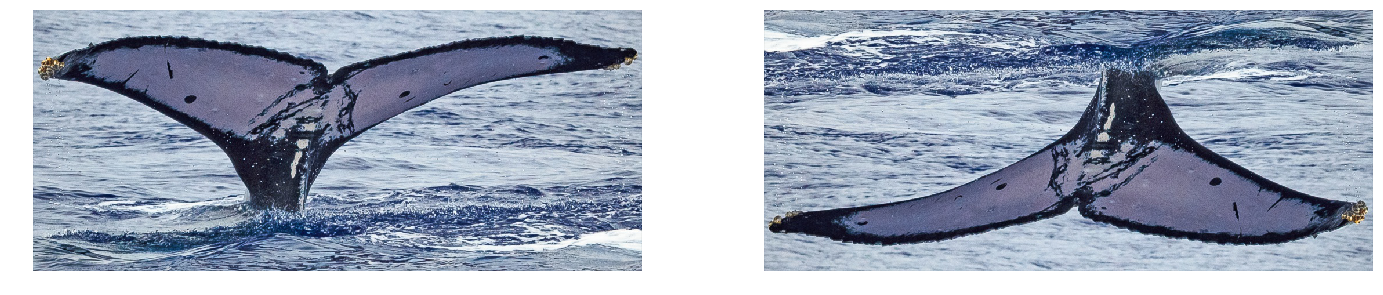

In [15]:
def read_raw_image(p):
    img = pil_image.open(expand_path(p))
    if p in rotate: img = img.rotate(180)
#     print(p)
    return img

p    = list(rotate)[0]
imgs = [pil_image.open(expand_path(p)), read_raw_image(p)]
show_whale(imgs)

In [16]:
# Read the bounding box data from the bounding box kernel (see reference above)
with open('../cache/bounding-box.pickle', 'rb') as f:
    p2bb = pickle.load(f)
list(p2bb.items())[:5]


[('0000e88ab.jpg', (243, 143, 860, 396)),
 ('0001f9222.jpg', (11, 78, 732, 238)),
 ('00029d126.jpg', (23, 23, 1026, 465)),
 ('00050a15a.jpg', (5, 151, 1006, 397)),
 ('0005c1ef8.jpg', (30, 155, 943, 323))]

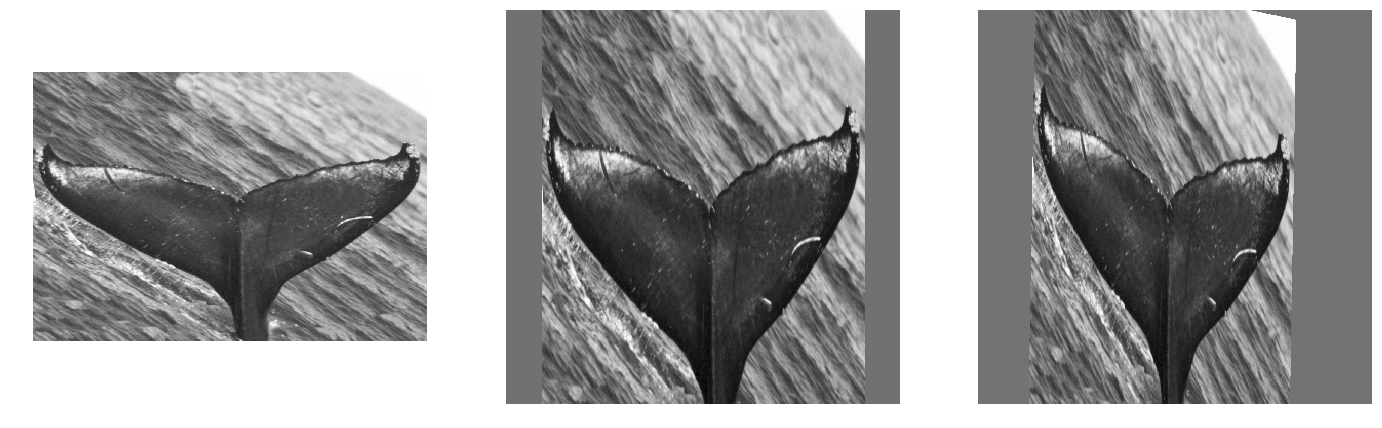

In [17]:
# Suppress annoying stderr output when importing keras.
import sys
import platform
old_stderr = sys.stderr
sys.stderr = open('/dev/null' if platform.system() != 'Windows' else 'nul', 'w')
import keras
sys.stderr = old_stderr

import random
from keras import backend as K
from keras.preprocessing.image import img_to_array,array_to_img
from scipy.ndimage import affine_transform

img_shape    = (384,384,1) # The image shape used by the model
anisotropy   = 2.15 # The horizontal compression ratio
crop_margin  = 0.05 # The margin added around the bounding box to compensate for bounding box inaccuracy

def build_transform(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    """
    Build a transformation matrix with the specified characteristics.
    """
    rotation        = np.deg2rad(rotation)
    shear           = np.deg2rad(shear)
    rotation_matrix = np.array([[np.cos(rotation), np.sin(rotation), 0], [-np.sin(rotation), np.cos(rotation), 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, height_shift], [0, 1, width_shift], [0, 0, 1]])
    shear_matrix    = np.array([[1, np.sin(shear), 0], [0, np.cos(shear), 0], [0, 0, 1]])
    zoom_matrix     = np.array([[1.0/height_zoom, 0, 0], [0, 1.0/width_zoom, 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, -height_shift], [0, 1, -width_shift], [0, 0, 1]])
    return np.dot(np.dot(rotation_matrix, shear_matrix), np.dot(zoom_matrix, shift_matrix))

def read_cropped_image(p, augment):
    """
    @param p : the name of the picture to read
    @param augment: True/False if data augmentation should be performed
    @return a numpy array with the transformed image
    """
    # If an image id was given, convert to filename
    if p in h2p: p = h2p[p]
    size_x,size_y = p2size[p]
    
    # Determine the region of the original image we want to capture based on the bounding box.
    x0,y0,x1,y1   = p2bb[p]
    if p in rotate: x0, y0, x1, y1 = size_x - x1, size_y - y1, size_x - x0, size_y - y0
    dx            = x1 - x0
    dy            = y1 - y0
    x0           -= dx*crop_margin
    x1           += dx*crop_margin + 1
    y0           -= dy*crop_margin
    y1           += dy*crop_margin + 1
    if (x0 < 0     ): x0 = 0
    if (x1 > size_x): x1 = size_x
    if (y0 < 0     ): y0 = 0
    if (y1 > size_y): y1 = size_y
    dx            = x1 - x0
    dy            = y1 - y0
    if dx > dy*anisotropy:
        dy  = 0.5*(dx/anisotropy - dy)
        y0 -= dy
        y1 += dy
    else:
        dx  = 0.5*(dy*anisotropy - dx)
        x0 -= dx
        x1 += dx

    # Generate the transformation matrix
    trans = np.array([[1, 0, -0.5*img_shape[0]], [0, 1, -0.5*img_shape[1]], [0, 0, 1]])
    trans = np.dot(np.array([[(y1 - y0)/img_shape[0], 0, 0], [0, (x1 - x0)/img_shape[1], 0], [0, 0, 1]]), trans)
    if augment:
        trans = np.dot(build_transform(
            random.uniform(-5, 5),
            random.uniform(-5, 5),
            random.uniform(0.8, 1.0),
            random.uniform(0.8, 1.0),
            random.uniform(-0.05*(y1 - y0), 0.05*(y1 - y0)),
            random.uniform(-0.05*(x1 - x0), 0.05*(x1 - x0))
            ), trans)
    trans = np.dot(np.array([[1, 0, 0.5*(y1 + y0)], [0, 1, 0.5*(x1 + x0)], [0, 0, 1]]), trans)

    # Read the image, transform to black and white and comvert to numpy array
    img   = read_raw_image(p).convert('L')
    img   = img_to_array(img)
    
    # Apply affine transformation
    matrix = trans[:2,:2]
    offset = trans[:2,2]
    img    = img.reshape(img.shape[:-1])
    img    = affine_transform(img, matrix, offset, output_shape=img_shape[:-1], order=1, mode='constant', cval=np.average(img))
    img    = img.reshape(img_shape)

    # Normalize to zero mean and unit variance
    img  -= np.mean(img, keepdims=True)
    img  /= np.std(img, keepdims=True) + K.epsilon()
    return img

def read_for_training(p):
    """
    Read and preprocess an image with data augmentation (random transform).
    """
    return read_cropped_image(p, True)

def read_for_validation(p):
    """
    Read and preprocess an image without data augmentation (use for testing).
    """
    return read_cropped_image(p, False)

p = list(tagged.keys())[312]
imgs = [
    read_raw_image(p),
    array_to_img(read_for_validation(p)),
    array_to_img(read_for_training(p))
]
show_whale(imgs, per_row=3)

In [18]:
from keras import regularizers
from keras.optimizers import Adam
from keras.engine.topology import Input
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, GlobalMaxPooling2D, Lambda, MaxPooling2D, Reshape
from keras.models import Model

def subblock(x, filter, **kwargs):
    x = BatchNormalization()(x)
    y = x
    y = Conv2D(filter, (1, 1), activation='relu', **kwargs)(y) # Reduce the number of features to 'filter'
    y = BatchNormalization()(y)
    y = Conv2D(filter, (3, 3), activation='relu', **kwargs)(y) # Extend the feature field
    y = BatchNormalization()(y)
    y = Conv2D(K.int_shape(x)[-1], (1, 1), **kwargs)(y) # no activation # Restore the number of original features
    y = Add()([x,y]) # Add the bypass connection
    y = Activation('relu')(y)
    return y

def build_model(lr, l2, activation='sigmoid'):

    ##############
    # BRANCH MODEL
    ##############
    regul  = regularizers.l2(l2)
    optim  = Adam(lr=lr)
    kwargs = {'padding':'same', 'kernel_regularizer':regul}

    inp = Input(shape=img_shape) # 384x384x1
    x   = Conv2D(64, (9,9), strides=2, activation='relu', **kwargs)(inp)

    x   = MaxPooling2D((2, 2), strides=(2, 2))(x) # 96x96x64
    for _ in range(2):
        x = BatchNormalization()(x)
        x = Conv2D(64, (3,3), activation='relu', **kwargs)(x)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 48x48x64
    x = BatchNormalization()(x)
    x = Conv2D(128, (1,1), activation='relu', **kwargs)(x) # 48x48x128
    for _ in range(4): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 24x24x128
    x = BatchNormalization()(x)
    x = Conv2D(256, (1,1), activation='relu', **kwargs)(x) # 24x24x256
    for _ in range(4): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 12x12x256
    x = BatchNormalization()(x)
    x = Conv2D(384, (1,1), activation='relu', **kwargs)(x) # 12x12x384
    for _ in range(4): x = subblock(x, 96, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 6x6x384
    x = BatchNormalization()(x)
    x = Conv2D(512, (1,1), activation='relu', **kwargs)(x) # 6x6x512
    for _ in range(4): x = subblock(x, 128, **kwargs)
    
    x             = GlobalMaxPooling2D()(x) # 512
    branch_model  = Model(inp, x)
    
    ############
    # HEAD MODEL
    ############
    mid        = 32
    xa_inp     = Input(shape=branch_model.output_shape[1:])
    xb_inp     = Input(shape=branch_model.output_shape[1:])
    x1         = Lambda(lambda x : x[0]*x[1])([xa_inp, xb_inp])
    x2         = Lambda(lambda x : x[0] + x[1])([xa_inp, xb_inp])
    x3         = Lambda(lambda x : K.abs(x[0] - x[1]))([xa_inp, xb_inp])
    x4         = Lambda(lambda x : K.square(x))(x3)
    x          = Concatenate()([x1, x2, x3, x4])
    x          = Reshape((4, branch_model.output_shape[1], 1), name='reshape1')(x)

    # Per feature NN with shared weight is implemented using CONV2D with appropriate stride.
    x          = Conv2D(mid, (4, 1), activation='relu', padding='valid')(x)
    x          = Reshape((branch_model.output_shape[1], mid, 1))(x)
    x          = Conv2D(1, (1, mid), activation='linear', padding='valid')(x)
    x          = Flatten(name='flatten')(x)
    
    # Weighted sum implemented as a Dense layer.
    x          = Dense(1, use_bias=True, activation=activation, name='weighted-average')(x)
    head_model = Model([xa_inp, xb_inp], x, name='head')

    ########################
    # SIAMESE NEURAL NETWORK
    ########################
    # Complete model is constructed by calling the branch model on each input image,
    # and then the head model on the resulting 512-vectors.
    img_a      = Input(shape=img_shape)
    img_b      = Input(shape=img_shape)
    xa         = branch_model(img_a)
    xb         = branch_model(img_b)
    x          = head_model([xa, xb])
    model      = Model([img_a, img_b], x)
    model.compile(optim, loss='binary_crossentropy', metrics=['binary_crossentropy', 'acc'])
    return model, branch_model, head_model

model, branch_model, head_model = build_model(64e-5,0)
head_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 512)          0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512)          0           input_2[0][0]                    
          

In [19]:
# !pip install pydot

In [20]:
# from keras.utils import plot_model
# plot_model(head_model, to_file='head-model.png')
# pil_image.open('head-model.png')

In [21]:
branch_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 384, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 192, 64) 5248        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 96, 96, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 96, 96, 64)   256         max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_2 (

In [22]:
with open('../data/exclude.txt', 'rt') as f: exclude = f.read().split('\n')[:-1]   
len(exclude)

34

In [23]:
# Find all the whales associated with an image id. It can be ambiguous as duplicate images may have different whale ids.
h2ws = {}
new_whale = 'new_whale'
for p,w in tagged.items():
    if w != new_whale: # Use only identified whales
        h = p2h[p]
        if h not in h2ws: h2ws[h] = []
        if w not in h2ws[h]: h2ws[h].append(w)
for h,ws in h2ws.items():
    if len(ws) > 1:
        h2ws[h] = sorted(ws)
len(h2ws)


19553

In [24]:
# For each whale, find the unambiguous images ids.
w2hs = {}
for h,ws in h2ws.items():
    if len(ws) == 1: # Use only unambiguous pictures
        if h2p[h] in exclude:
            print(h) # Skip excluded images
        else:
            w = ws[0]
            if w not in w2hs: w2hs[w] = []
            if h not in w2hs[w]: w2hs[w].append(h)
for w,hs in w2hs.items():
    if len(hs) > 1:
        w2hs[w] = sorted(hs)
len(w2hs)

ebf094854a2bb1d6
f86bcf9487653848
807b19b6766d09ce
bc984f67a31b48a6
c5313ec3c0343bcf
9dc39bb4833cc3c8
afa994d4416b2ab6
c0352f2194b7fcca
c4cc196f46bc8cce
c0c0753e9fcf4368
d8dc91b13fae8a18
f3ad8c8cb2b38c8c
f18c966fb836c90c
f8908e4ee223f758
a2d5d5eae64f2a01
96c949b632e90d3e
e8d1960f60b13fca
d08f9d61729e8d61
90376cc843f6b9a3
e92d90d2616f0f9c
c96d1296e96b16b4
c7882c3359ec7327
f43183739a8f53c4


6818

In [25]:
# Find the list of training images, keep only whales with at least two images.
train = [] # A list of training image ids
for hs in w2hs.values():
    if len(hs) > 1:
        train += hs
random.shuffle(train)
train_set = set(train)

w2ts = {} # Associate the image ids from train to each whale id.
for w,hs in w2hs.items():
    for h in hs:
        if h in train_set:
            if w not in w2ts: w2ts[w] = []
            if h not in w2ts[w]: w2ts[w].append(h)
for w,ts in w2ts.items(): w2ts[w] = np.array(ts)
    
t2i = {} # The position in train of each training image id
for i,t in enumerate(train): t2i[t] = i

len(train),len(w2ts)

(10795, 2645)

In [26]:
from keras.utils import Sequence

# First try to use lapjv Linear Assignment Problem solver as it is much faster.
# At the time I am writing this, kaggle kernel with custom package fail to commit.
# scipy can be used as a fallback, but it is too slow to run this kernel under the time limit
# As a workaround, use scipy with data partitioning.
# Because algorithm is O(n^3), small partitions are much faster, but not what produced the submitted solution
try:
    from lap import lapjv
    segment = False
except ImportError:
    print('Module lap not found, emulating with much slower scipy.optimize.linear_sum_assignment')
    segment = True
    from scipy.optimize import linear_sum_assignment

class TrainingData(Sequence):
    def __init__(self, score, steps=1000, batch_size=32):
        """
        @param score the cost matrix for the picture matching
        @param steps the number of epoch we are planning with this score matrix
        """
        super(TrainingData, self).__init__()
        self.score      = -score # Maximizing the score is the same as minimuzing -score.
        self.steps      = steps
        self.batch_size = batch_size
        for ts in w2ts.values():
            idxs = [t2i[t] for t in ts]
            for i in idxs:
                for j in idxs:
                    self.score[i,j] = 10000.0 # Set a large value for matching whales -- eliminates this potential pairing
        self.on_epoch_end()
    def __getitem__(self, index):
        start = self.batch_size*index
        end   = min(start + self.batch_size, len(self.match) + len(self.unmatch))
        size  = end - start
        assert size > 0
        a     = np.zeros((size,) + img_shape, dtype=K.floatx())
        b     = np.zeros((size,) + img_shape, dtype=K.floatx())
        c     = np.zeros((size,1), dtype=K.floatx())
        j     = start//2
        for i in range(0, size, 2):
            a[i,  :,:,:] = read_for_training(self.match[j][0])
            b[i,  :,:,:] = read_for_training(self.match[j][1])
            c[i,  0    ] = 1 # This is a match
            a[i+1,:,:,:] = read_for_training(self.unmatch[j][0])
            b[i+1,:,:,:] = read_for_training(self.unmatch[j][1])
            c[i+1,0    ] = 0 # Different whales
            j           += 1
        return [a,b],c
    def on_epoch_end(self):
        if self.steps <= 0: return # Skip this on the last epoch.
        self.steps     -= 1
        self.match      = []
        self.unmatch    = []
        if segment:
            # Using slow scipy. Make small batches.
            # Because algorithm is O(n^3), small batches are much faster.
            # However, this does not find the real optimum, just an approximation.
            tmp   = []
            batch = 512
            for start in range(0, score.shape[0], batch):
                end = min(score.shape[0], start + batch)
                _, x = linear_sum_assignment(self.score[start:end, start:end])
                tmp.append(x + start)
            x = np.concatenate(tmp)
        else:
            _,_,x = lapjv(self.score) # Solve the linear assignment problem
        y = np.arange(len(x),dtype=np.int32)

        # Compute a derangement for matching whales
        for ts in w2ts.values():
            d = ts.copy()
            while True:
                random.shuffle(d)
                if not np.any(ts == d): break
            for ab in zip(ts,d): self.match.append(ab)

        # Construct unmatched whale pairs from the LAP solution.
        for i,j in zip(x,y):
            if i == j:
                print(self.score)
                print(x)
                print(y)
                print(i,j)
            assert i != j
            self.unmatch.append((train[i],train[j]))

        # Force a different choice for an eventual next epoch.
        self.score[x,y] = 10000.0
        self.score[y,x] = 10000.0
        random.shuffle(self.match)
        random.shuffle(self.unmatch)
        # print(len(self.match), len(train), len(self.unmatch), len(train))
        assert len(self.match) == len(train) and len(self.unmatch) == len(train)
    def __len__(self):
        return (len(self.match) + len(self.unmatch) + self.batch_size - 1)//self.batch_size

Module lap not found, emulating with much slower scipy.optimize.linear_sum_assignment


In [27]:
# Test on a batch of 32 with random costs.
score = np.random.random_sample(size=(len(train),len(train)))
data = TrainingData(score)
(a, b), c = data[0]
a.shape, b.shape, c.shape


((32, 384, 384, 1), (32, 384, 384, 1), (32, 1))

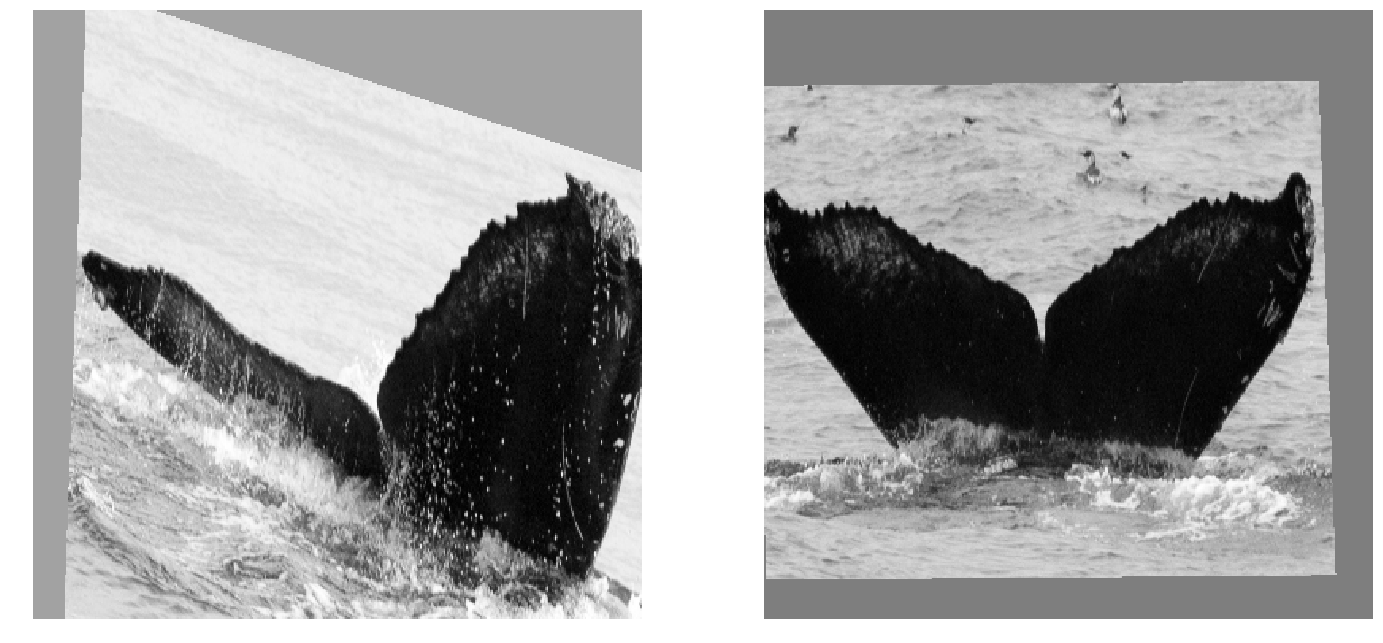

In [28]:
# First pair is for matching whale
imgs = [array_to_img(a[0]), array_to_img(b[0])]
show_whale(imgs, per_row=2)

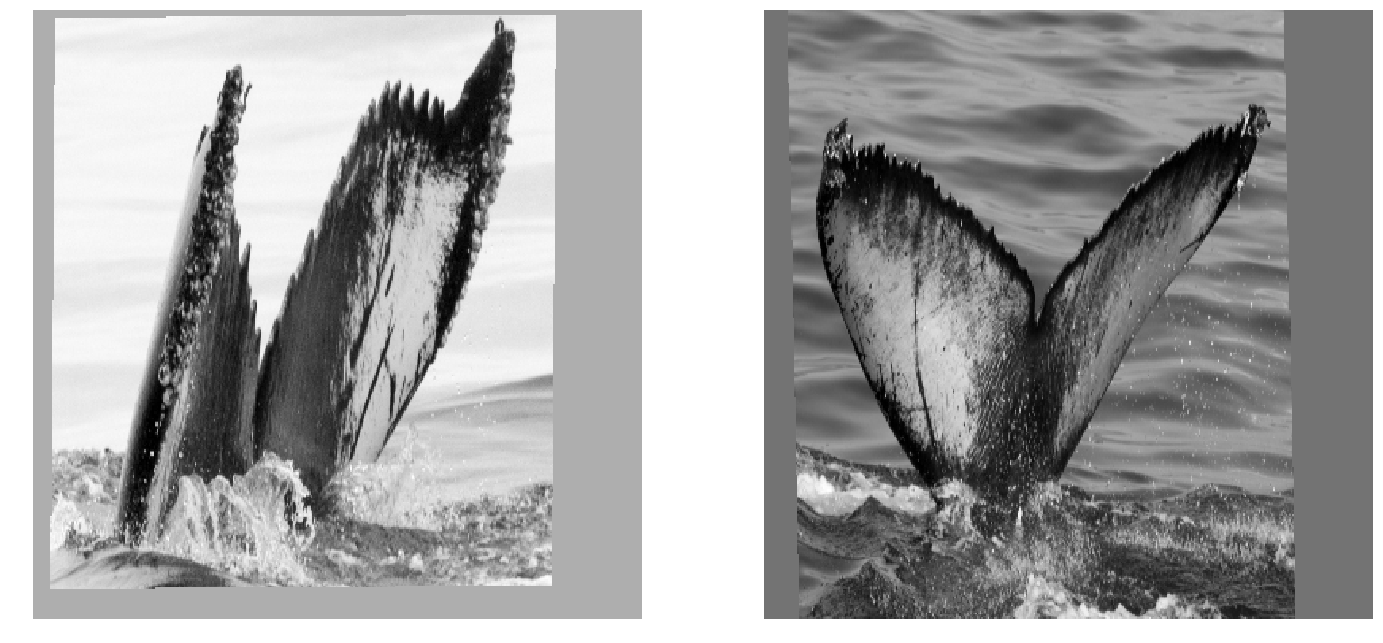

In [29]:
# Second pair is for different whales
imgs = [array_to_img(a[1]), array_to_img(b[1])]
show_whale(imgs, per_row=2)

In [30]:
# A Keras generator to evaluate only the BRANCH MODEL
class FeatureGen(Sequence):
    def __init__(self, data, batch_size=64, verbose=1):
        super(FeatureGen, self).__init__()
        self.data       = data
        self.batch_size = batch_size
        self.verbose    = verbose
        if self.verbose > 0: self.progress = tqdm_notebook(total=len(self), desc='Features')
    def __getitem__(self, index):
        start = self.batch_size*index
        size  = min(len(self.data) - start, self.batch_size)
        a     = np.zeros((size,) + img_shape, dtype=K.floatx())
        for i in range(size): a[i,:,:,:] = read_for_validation(self.data[start + i])
        if self.verbose > 0: 
            self.progress.update()
            if self.progress.n >= len(self): self.progress.close()
        return a
    def __len__(self):
        return (len(self.data) + self.batch_size - 1)//self.batch_size

# A Keras generator to evaluate on the HEAD MODEL on features already pre-computed.
# It computes only the upper triangular matrix of the cost matrix if y is None.
class ScoreGen(Sequence):
    def __init__(self, x, y=None, batch_size=2048, verbose=1):
        super(ScoreGen, self).__init__()
        self.x          = x
        self.y          = y
        self.batch_size = batch_size
        self.verbose    = verbose
        if y is None:
            self.y           = self.x
            self.ix, self.iy = np.triu_indices(x.shape[0],1)
        else:
            self.iy, self.ix = np.indices((y.shape[0],x.shape[0]))
            self.ix          = self.ix.reshape((self.ix.size,))
            self.iy          = self.iy.reshape((self.iy.size,))
        self.subbatch = (len(self.x) + self.batch_size - 1)//self.batch_size
        if self.verbose > 0: self.progress = tqdm_notebook(total=len(self), desc='Scores')
    def __getitem__(self, index):
        start = index*self.batch_size
        end   = min(start + self.batch_size, len(self.ix))
        a     = self.y[self.iy[start:end],:]
        b     = self.x[self.ix[start:end],:]
        if self.verbose > 0: 
            self.progress.update()
            if self.progress.n >= len(self): self.progress.close()
        return [a,b]
    def __len__(self):
        return (len(self.ix) + self.batch_size - 1)//self.batch_size

In [31]:
# !pip install keras_tqdm

In [32]:
from keras_tqdm import TQDMNotebookCallback

def set_lr(model, lr):
    K.set_value(model.optimizer.lr, float(lr))

def get_lr(model):
    return K.get_value(model.optimizer.lr)

def score_reshape(score, x, y=None):
    """
    Tranformed the packed matrix 'score' into a square matrix.
    @param score the packed matrix
    @param x the first image feature tensor
    @param y the second image feature tensor if different from x
    @result the square matrix
    """
    if y is None:
        # When y is None, score is a packed upper triangular matrix.
        # Unpack, and transpose to form the symmetrical lower triangular matrix.
        m = np.zeros((x.shape[0],x.shape[0]), dtype=K.floatx())
        m[np.triu_indices(x.shape[0],1)] = score.squeeze()
        m += m.transpose()
    else:
        m        = np.zeros((y.shape[0],x.shape[0]), dtype=K.floatx())
        iy,ix    = np.indices((y.shape[0],x.shape[0]))
        ix       = ix.reshape((ix.size,))
        iy       = iy.reshape((iy.size,))
        m[iy,ix] = score.squeeze()
    return m

def compute_score(verbose=1):
    """
    Compute the score matrix by scoring every pictures from the training set against every other picture O(n^2).
    """
    features = branch_model.predict_generator(FeatureGen(train, verbose=verbose), max_queue_size=12, workers=6, verbose=0)
    score    = head_model.predict_generator(ScoreGen(features, verbose=verbose), max_queue_size=12, workers=6, verbose=0)
    score    = score_reshape(score, features)
    return features, score

def make_steps(step, ampl):
    """
    Perform training epochs
    @param step Number of epochs to perform
    @param ampl the K, the randomized component of the score matrix.
    """
    global w2ts, t2i, steps, features, score, histories
    
    # shuffle the training pictures
    random.shuffle(train)
    
    # Map whale id to the list of associated training picture hash value
    w2ts = {}
    for w,hs in w2hs.items():
        for h in hs:
            if h in train_set:
                if w not in w2ts: w2ts[w] = []
                if h not in w2ts[w]: w2ts[w].append(h)
    for w,ts in w2ts.items(): w2ts[w] = np.array(ts)

    # Map training picture hash value to index in 'train' array    
    t2i  = {}
    for i,t in enumerate(train): t2i[t] = i    

    # Compute the match score for each picture pair
    features, score = compute_score()
    
    # Train the model for 'step' epochs
    history = model.fit_generator(
        TrainingData(score + ampl*np.random.random_sample(size=score.shape), steps=step, batch_size=32),
        initial_epoch=steps, epochs=steps + step, max_queue_size=12, workers=6, verbose=0,
        callbacks=[
            TQDMNotebookCallback(leave_inner=True, metric_format='{value:0.3f}')
        ]).history
    steps += step
    
    # Collect history data
    history['epochs'] = steps
    history['ms'    ] = np.mean(score)
    history['lr'    ] = get_lr(model)
    print(history['epochs'],history['lr'],history['ms'])
    histories.append(history)

In [33]:
model_name = '../cache/mpiotte-standard2'
histories  = []
steps      = 0

In [33]:
if isfile('../cache/mpiotte-standard2-1.model'):
    tmp = keras.models.load_model('../cache/mpiotte-standard2-1.model')
    model.set_weights(tmp.get_weights())
else:
    # epoch -> 10
    make_steps(10, 1000)
    model.save('../cache/mpiotte-standard2-1.model')


10 0.00064 0.501009


In [34]:
if isfile('../cache/mpiotte-standard2-2.model'):
    tmp = keras.models.load_model('../cache/mpiotte-standard2-2.model')
    model.set_weights(tmp.get_weights())
else:
    ampl = 100.0
    for ii in range(10):
        name = '../cache/mpiotte-standard2-1-{}.model'.format(ii)
        if isfile(name):
            continue
        if ii==0:
            name = '../cache/mpiotte-standard2-1.model'
        else:
            name = '../cache/mpiotte-standard2-1-{}.model'.format(ii-1) 
        tmp = keras.models.load_model(name)
        model.set_weights(tmp.get_weights())
        print('noise ampl.  = ', ampl)
        make_steps(5, ampl)
        ampl = max(1.0, 100**-0.1*ampl)
        name = '../cache/mpiotte-standard2-1-{}.model'.format(ii)
        model.save(name)
    model.save('../cache/mpiotte-standard2-2.model')

noise ampl.  =  100.0



15 0.00064 0.417114
noise ampl.  =  63.09573444801933



20 0.00064 0.200465
noise ampl.  =  39.81071705534973



25 0.00064 0.173957
noise ampl.  =  25.118864315095802



30 0.00064 0.140753
noise ampl.  =  15.848931924611136



35 0.00064 0.101589
noise ampl.  =  10.000000000000002



40 0.00064 0.103903
noise ampl.  =  6.309573444801933



45 0.00064 0.0931482
noise ampl.  =  3.981071705534973



50 0.00064 0.0586499
noise ampl.  =  2.5118864315095806



55 0.00064 0.0434482
noise ampl.  =  1.5848931924611138



60 0.00064 0.0433887


In [ ]:
if isfile('../cache/mpiotte-standard2-2.model'):
    # epoch -> 150
    for ii in range(18): 
        name = '../cache/mpiotte-standard2-2-{}.model'.format(ii)
        if isfile(name):
            continue
        if ii==0:
            name = '../cache/mpiotte-standard2-2.model'
        else:
            name = '../cache/mpiotte-standard2-2-{}.model'.format(ii-1) 
        tmp = keras.models.load_model(name)
        model.set_weights(tmp.get_weights())
        make_steps(5, 1.0)
        name = '../cache/mpiotte-standard2-2-{}.model'.format(ii)
        model.save(name)
    model.save('../cache/mpiotte-standard2-3.model')


65 0.00064 0.0227074



70 0.00064 0.0322057



75 0.00064 0.0167982



80 0.00064 0.0191708



85 0.00064 0.0168868



90 0.00064 0.0167937



95 0.00064 0.0104104



100 0.00064 0.0100518



105 0.00064 0.0119716



110 0.00064 0.00835696



115 0.00064 0.00741917



120 0.00064 0.0108328



125 0.00064 0.00917894



130 0.00064 0.0104925



135 0.00064 0.00964148



140 0.00064 0.00780523



145 0.00064 0.00790461



150 0.00064 0.00564795


In [ ]:
if isfile('../cache/mpiotte-standard2-3.model'):
    # epoch -> 200
    set_lr(model, 16e-5)
    for ii in range(10):
        name = '../cache/mpiotte-standard2-3-{}.model'.format(ii)
        if isfile(name):
            continue
        if ii==0:
            name = '../cache/mpiotte-standard2-3.model'
        else:
            name = '../cache/mpiotte-standard2-3-{}.model'.format(ii-1) 
        tmp = keras.models.load_model(name)
        model.set_weights(tmp.get_weights())
        make_steps(5, 0.5)
        name = '../cache/mpiotte-standard2-3-{}.model'.format(ii)
        model.save(name)
    model.save('../cache/mpiotte-standard2-4.model')


155 0.00016 0.0120354



160 0.00016 0.00199259



165 0.00016 0.00251492



170 0.00016 0.00304126



175 0.00016 0.00217812



180 0.00016 0.00227635



185 0.00016 0.00234211



190 0.00016 0.00218227



195 0.00016 0.00199115



200 0.00016 0.00209062


In [ ]:
if isfile('../cache/mpiotte-standard2-4.model'):
    # epoch -> 240
    set_lr(model, 4e-5)
    for ii in range(8):
        name = '../cache/mpiotte-standard2-4-{}.model'.format(ii)
        if isfile(name):
            continue
        if ii==0:
            name = '../cache/mpiotte-standard2-4.model'
        else:
            name = '../cache/mpiotte-standard2-4-{}.model'.format(ii-1) 
        tmp = keras.models.load_model(name)
        model.set_weights(tmp.get_weights())
        make_steps(5, 0.25)
        name = '../cache/mpiotte-standard2-4-{}.model'.format(ii)
        model.save(name)
    model.save('../cache/mpiotte-standard2-5.model')


205 4e-05 0.00217602



210 4e-05 0.00155035



215 4e-05 0.00184244



220 4e-05 0.00164656



225 4e-05 0.00176614



230 4e-05 0.00171549



235 4e-05 0.0016552



240 4e-05 0.00175436


In [ ]:
if isfile('../cache/mpiotte-standard2-5.model'):
    # epoch -> 250
    set_lr(model, 1e-5)
    for ii in range(8):
        name = '../cache/mpiotte-standard2-5-{}.model'.format(ii)
        if isfile(name):
            continue
        if ii==0:
            name = '../cache/mpiotte-standard2-5.model'
        else:
            name = '../cache/mpiotte-standard2-5-{}.model'.format(ii-1) 
        tmp = keras.models.load_model(name)
        model.set_weights(tmp.get_weights())
        make_steps(5, 0.25)
        name = '../cache/mpiotte-standard2-5-{}.model'.format(ii)
        model.save(name)
    model.save('../cache/mpiotte-standard2-6.model')


245 1e-05 0.00161335



250 1e-05 0.00148299



255 1e-05 0.0015347



260 1e-05 0.00149776



265 1e-05 0.00147644



270 1e-05 0.0014694



275 1e-05 0.00148941



280 1e-05 0.00148251


In [ ]:
if isfile('../cache/mpiotte-standard2-6.model'):
    tmp = keras.models.load_model('../cache/mpiotte-standard2-6.model')
    model.set_weights(tmp.get_weights())
    
    # epoch -> 300
    weights = model.get_weights()
    model, branch_model, head_model = build_model(64e-5,0.0002)
    model.set_weights(weights)
    for ii in range(10):
        name = '../cache/mpiotte-standard2-6-{}.model'.format(ii)
        if isfile(name):
            continue
        if ii !=0:
            name = '../cache/mpiotte-standard2-6-{}.model'.format(ii-1)
            if isfile(name):
                tmp = keras.models.load_model(name)
                model.set_weights(tmp.get_weights())
        make_steps(5, 1.0)
        name = '../cache/mpiotte-standard2-6-{}.model'.format(ii)
        model.save(name)
    model.save('../cache/mpiotte-standard2-7.model')


285 0.00064 0.00149487



290 0.00064 0.157659



295 0.00064 0.104696



300 0.00064 0.116527



305 0.00064 0.124797



310 0.00064 0.0839448



315 0.00064 0.102906



320 0.00064 0.127506



325 0.00064 0.0880812



330 0.00064 0.101426


In [ ]:
if isfile('../cache/mpiotte-standard2-7.model'):
    # epoch -> 350
    set_lr(model, 16e-5)
    for ii in range(10):
        name = '../cache/mpiotte-standard2-7-{}.model'.format(ii)
        if isfile(name):
            continue
        if ii==0:
            name = '../cache/mpiotte-standard2-7.model'
        else:
            name = '../cache/mpiotte-standard2-7-{}.model'.format(ii-1) 
        tmp = keras.models.load_model(name)
        model.set_weights(tmp.get_weights())
        make_steps(5, 0.5)
        name = '../cache/mpiotte-standard2-7-{}.model'.format(ii)
        model.save(name)
    model.save('../cache/mpiotte-standard2-8.model')


335 0.00016 0.0657195



340 0.00016 0.0316488



345 0.00016 0.0244744



350 0.00016 0.0273509



355 0.00016 0.0200126



360 0.00016 0.0173606



365 0.00016 0.0142314



370 0.00016 0.0151209



375 0.00016 0.013737



380 0.00016 0.015782


In [34]:
if isfile('../cache/mpiotte-standard2-8.model'):
    # epoch -> 390
    set_lr(model, 4e-5)
    for ii in range(8):
        name = '../cache/mpiotte-standard2-8-{}.model'.format(ii)
        if isfile(name):
            continue
        if ii==0:
            name = '../cache/mpiotte-standard2-8.model'
        else:
            name = '../cache/mpiotte-standard2-8-{}.model'.format(ii-1) 
        tmp = keras.models.load_model(name)
        model.set_weights(tmp.get_weights())
        make_steps(5, 0.25)
        name = '../cache/mpiotte-standard2-8-{}.model'.format(ii)
        model.save(name)
    model.save('../cache/mpiotte-standard2-9.model')


5 4e-05 0.00535466



10 4e-05 0.00443799



15 4e-05 0.00496233



20 4e-05 0.00345582



25 4e-05 0.00433553



30 4e-05 0.00349386


In [35]:
if isfile('../cache/mpiotte-standard2-9.model'):
    # epoch -> 400
    set_lr(model, 1e-5)
    for ii in range(2):
        name = '../cache/mpiotte-standard2-9-{}.model'.format(ii)
        if isfile(name):
            continue
        if ii==0:
            name = '../cache/mpiotte-standard2-9.model'
        else:
            name = '../cache/mpiotte-standard2-9-{}.model'.format(ii-1) 
        tmp = keras.models.load_model(name)
        model.set_weights(tmp.get_weights())
        make_steps(5, 0.25)
        name = '../cache/mpiotte-standard2-9-{}.model'.format(ii)
        model.save(name)
    model.save('../cache/mpiotte-standard2-10.model')


35 1e-05 0.00346012



40 1e-05 0.00321191


In [36]:
# if isfile('../cache/mpiotte-standard2.model'):
#     tmp = keras.models.load_model('../cache/mpiotte-standard2.model')
#     model.set_weights(tmp.get_weights())
# else:
#     # epoch -> 10
#     make_steps(10, 1000)
#     ampl = 100.0
#     for _ in range(10):
#         print('noise ampl.  = ', ampl)
#         make_steps(5, ampl)
#         ampl = max(1.0, 100**-0.1*ampl)
#     # epoch -> 150
#     for _ in range(18): make_steps(5, 1.0)
#     # epoch -> 200
#     set_lr(model, 16e-5)
#     for _ in range(10): make_steps(5, 0.5)
#     # epoch -> 240
#     set_lr(model, 4e-5)
#     for _ in range(8): make_steps(5, 0.25)
#     # epoch -> 250
#     set_lr(model, 1e-5)
#     for _ in range(2): make_steps(5, 0.25)
#     # epoch -> 300
#     weights = model.get_weights()
#     model, branch_model, head_model = build_model(64e-5,0.0002)
#     model.set_weights(weights)
#     for _ in range(10): make_steps(5, 1.0)
#     # epoch -> 350
#     set_lr(model, 16e-5)
#     for _ in range(10): make_steps(5, 0.5)    
#     # epoch -> 390
#     set_lr(model, 4e-5)
#     for _ in range(8): make_steps(5, 0.25)
#     # epoch -> 400
#     set_lr(model, 1e-5)
#     for _ in range(2): make_steps(5, 0.25)
#     model.save('../cache/mpiotte-standard2.model')

In [37]:
# Not computing the submission in this notebook because it is a little slow. It takes about 15 minutes on setup with a GTX 1080.
import gzip

def prepare_submission(threshold, filename):
    """
    Generate a Kaggle submission file.
    @param threshold the score given to 'new_whale'
    @param filename the submission file name
    """
    vtop  = 0
    vhigh = 0
    pos   = [0,0,0,0,0,0]
    with gzip.open(filename, 'wt', newline='\n') as f:
        f.write('Image,Id\n')
        for i,p in enumerate(tqdm_notebook(submit)):
            t = []
            s = set()
            a = score[i,:]
            for j in list(reversed(np.argsort(a))):
                h = known[j]
                if a[j] < threshold and new_whale not in s:
                    pos[len(t)] += 1
                    s.add(new_whale)
                    t.append(new_whale)
                    if len(t) == 5: break;
                for w in h2ws[h]:
                    assert w != new_whale
                    if w not in s:
                        if a[j] > 1.0:
                            vtop += 1
                        elif a[j] >= threshold:
                            vhigh += 1
                        s.add(w)
                        t.append(w)
                        if len(t) == 5: break;
                if len(t) == 5: break;
            if new_whale not in s: pos[5] += 1
            assert len(t) == 5 and len(s) == 5
            f.write(p + ',' + ' '.join(t[:5]) + '\n')
    return vtop,vhigh,pos

if True:
    # Find elements from training sets not 'new_whale'
    h2ws = {}
    for p,w in tagged.items():
        if w != new_whale: # Use only identified whales
            h = p2h[p]
            if h not in h2ws: h2ws[h] = []
            if w not in h2ws[h]: h2ws[h].append(w)
    known = sorted(list(h2ws.keys()))

    # Dictionary of picture indices
    h2i   = {}
    for i,h in enumerate(known): h2i[h] = i

    # Evaluate the model.
    fknown  = branch_model.predict_generator(FeatureGen(known), max_queue_size=20, workers=10, verbose=0)
    fsubmit = branch_model.predict_generator(FeatureGen(submit), max_queue_size=20, workers=10, verbose=0)
    score   = head_model.predict_generator(ScoreGen(fknown, fsubmit), max_queue_size=20, workers=10, verbose=0)
    score   = score_reshape(score, fknown, fsubmit)

    # Generate the subsmission file.
    prepare_submission(0.99, '../submissions/sub2.csv.gz')